In [258]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from matplotlib.patches import Patch

# replace with your own relative file path
df = pd.read_csv(r"C:\Users\justi\OneDrive\Desktop\BU RISE\github\data_twitter\clean_tweets_directed.csv", sep = ",")
len(df)


3655957

In [ ]:
'''
Bridging users = users that identify with an ideology,
and who interact with users that align with their own ideologies 
and users who don't
'''

df['PartyName'] = df['PartyName'].str.title()
affil_map = df.groupby('From-User-Id')['Implied_Political_Affiliation'] \
                         .agg(lambda x: x.mode().iloc[0])

df['To-Ideology'] = df['To-User-Id'].map(affil_map)


df_filtered = df[df['To-Ideology'].isin(['Democrat','Republican'])]

interactions = df_filtered.pivot_table(index='From-User-Id',
               columns='To-Ideology',
               values='Score',   
               aggfunc='count',
               fill_value=0)

strongly_affiliated = affil_map[~affil_map.isin(['Inconclusive'])].index
interactions = interactions.loc[interactions.index.intersection(strongly_affiliated)]

bridging_users = interactions[(interactions['Democrat'] > 0) & (interactions['Republican'] > 0)].index.tolist()

In [260]:
df['Is_Bridging_User'] = df['From-User-Id'].isin(bridging_users)
df['Is_Recipient_Bridging'] = df['To-User-Id'].isin(bridging_users)
print(len(bridging_users))

144107


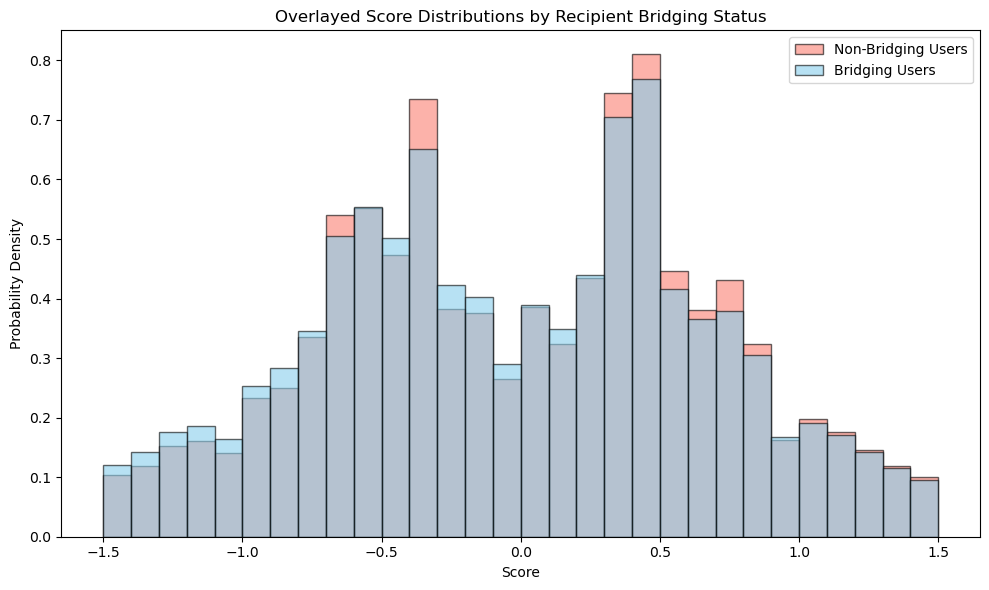

In [261]:
df1 = df[df['Is_Bridging_User'] == True]  
df2 = df[df['Is_Bridging_User'] == False]


plt.figure(figsize=(10,6))
plt.hist(df2['Score'], bins=30, density=True, alpha=0.6, label='Non-Bridging Users', color='salmon', edgecolor='black',range=(-1.5,1.5))
plt.hist(df1['Score'], bins=30, density=True, alpha=0.6, label='Bridging Users', color='skyblue', edgecolor='black',range=(-1.5,1.5))
plt.title("Overlayed Score Distributions by Recipient Bridging Status")
plt.xlabel("Score")
plt.ylabel("Probability Density")
plt.tight_layout()
plt.legend()
plt.show()

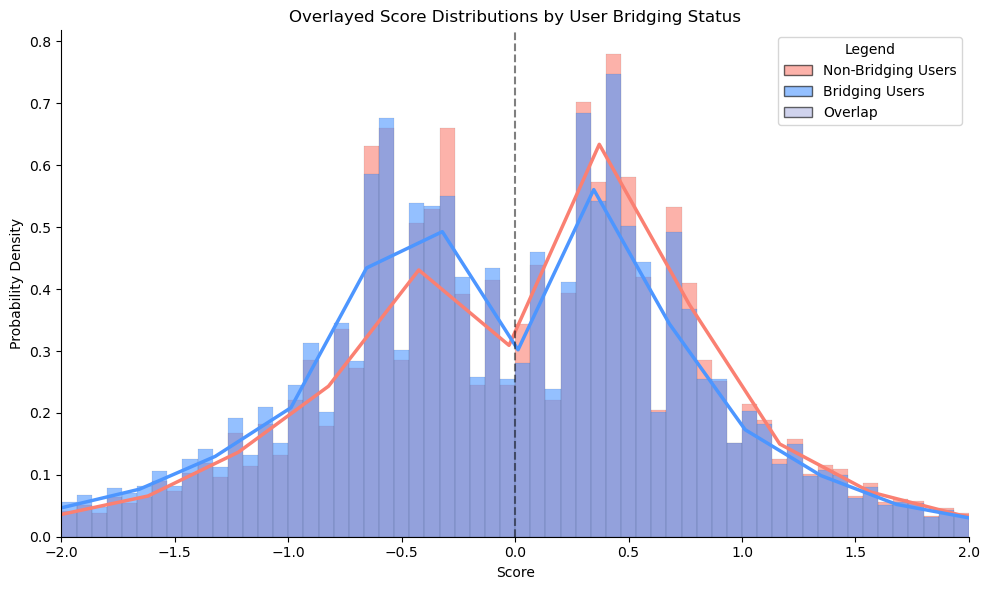

794714 2366836


In [279]:
from matplotlib.patches import Patch
column = 'Is_Bridging_User'
axis_labels = []
if column == 'Is_Recipient_Bridging':
    axis_labels = ('Non-Bridging Recipient', 'Bridging Recipient',)
elif column == 'Is_Bridging_User':
    axis_labels = ('Non-Bridging Users', 'Bridging Users',)

filtered_df = df[df['Implied_Political_Affiliation'].isin(['Democrat', 'Republican'])]
filtered_df = filtered_df[filtered_df['Implied_Political_Affiliation'] != filtered_df['To-Ideology']]

df_bridge = filtered_df[filtered_df[column] == True]
df_non = df[df[column] == False]

plt.figure(figsize=(10,6))
sns.histplot(df_non['Score'], bins=60, kde=True, kde_kws={}, line_kws={'linewidth': 2.5, 'alpha' : 1.0}, alpha = 0.6, stat='density', label=axis_labels[0], color= 'salmon', binrange=(-2.0,2.0))
sns.histplot(df_bridge['Score'], bins=60, kde=True, kde_kws={}, line_kws={'linewidth': 2.5, 'alpha' : 1.0}, alpha = 0.6, stat='density', label=axis_labels[1], color='#4D96FF', binrange=(-2.0,2.0))
plt.title("Overlayed Score Distributions by User Bridging Status")
plt.xlabel("Score")
plt.xlim(-2.0,2.0)
plt.ylabel("Probability Density")
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
plt.tight_layout()

custom_legend = [
    Patch(facecolor='salmon', edgecolor='black', alpha=0.6, label=axis_labels[0]),
    Patch(facecolor='#4D96FF', edgecolor='black', alpha=0.6, label=axis_labels[1]),
    Patch(facecolor='#B1B6E2', edgecolor='black', alpha=0.6, label='Overlap') 
]
plt.legend(handles=custom_legend, title="Legend")

sns.despine()
plt.show()

print(len(df_bridge),len(df_non))

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

X_bridge = df[df['Is_Bridging_User'] == True]['Score'].dropna().values.reshape(-1, 1)
X_nonbridge = df[df['Is_Bridging_User'] == False]['Score'].dropna().values.reshape(-1, 1)

gmm_bridge = GaussianMixture(n_components=2, random_state=0).fit(X_bridge)
gmm_nonbridge = GaussianMixture(n_components=2, random_state=0).fit(X_nonbridge)

X_all = df['Score'].dropna().values.reshape(-1, 1)
gmm_pooled = GaussianMixture(n_components=2, random_state=0).fit(X_all)

logL_pooled = gmm_pooled.score(X_all) * len(X_all)
logL_sep = gmm_bridge.score(X_bridge) * len(X_bridge) + gmm_nonbridge.score(X_nonbridge) * len(X_nonbridge)

LR_stat = 2 * (logL_sep - logL_pooled)

df_params = (gmm_bridge.means_.size + gmm_bridge.covariances_.size + gmm_bridge.weights_.size) + \
            (gmm_nonbridge.means_.size + gmm_nonbridge.covariances_.size + gmm_nonbridge.weights_.size) - \
            (gmm_pooled.means_.size + gmm_pooled.covariances_.size + gmm_pooled.weights_.size)

from scipy.stats import chi2
p_value = 1 - chi2.cdf(LR_stat, df=df_params)

print(f"Likelihood Ratio Statistic: {LR_stat:.2f}")
print(f"Degrees of Freedom: {df_params}")
print(f"P-value: {p_value:.4e}")


Likelihood Ratio Statistic: 11971.48
Degrees of Freedom: 6
P-value: 0.0000e+00


In [280]:
# REMEMBER RUN CELL ABOVE FIRST

kde_non = gaussian_kde(df_non['Score'].dropna())
kde_bridge = gaussian_kde(df_bridge['Score'].dropna())
min_score = min(df_non['Score'].min(), df_bridge['Score'].min())
max_score = max(df_non['Score'].max(), df_bridge['Score'].max())
prob_non_neg = quad(kde_non, min_score, 0)[0]
prob_bridge_neg = quad(kde_bridge, min_score, 0)[0]

print(f"Estimated P(Score < 0 | Non-Bridging User): {prob_non_neg:.4f}")
print(f"Estimated P(Score < 0 | Bridging User): {prob_bridge_neg:.4f}")

prob_non_pos = quad(kde_non, 0, max_score)[0]
prob_bridge_pos = quad(kde_bridge, 0, max_score)[0]

print(f"Estimated P(Score > 0 | Non-Bridging User): {prob_non_pos:.4f}")
print(f"Estimated P(Score > 0 | Bridging User): {prob_bridge_pos:.4f}")


C:\Users\justi\AppData\Local\Temp\ipykernel_9016\2223768529.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  prob_non_neg = quad(kde_non, min_score, 0)[0]
C:\Users\justi\AppData\Local\Temp\ipykernel_9016\2223768529.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and ca

Estimated P(Score < 0 | Non-Bridging User): 0.4897
Estimated P(Score < 0 | Bridging User): 0.5151


C:\Users\justi\AppData\Local\Temp\ipykernel_9016\2223768529.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  prob_non_pos = quad(kde_non, 0, max_score)[0]


Estimated P(Score > 0 | Non-Bridging User): 0.5103
Estimated P(Score > 0 | Bridging User): 0.4849


C:\Users\justi\AppData\Local\Temp\ipykernel_9016\2223768529.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  prob_bridge_pos = quad(kde_bridge, 0, max_score)[0]


In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

neg_bridge = (df_bridge['Score'] < 0).sum()
neg_non = (df_non['Score'] < 0).sum()
n_bridge = df_bridge['Score'].notna().sum()
n_non = df_non['Score'].notna().sum()
count = np.array([neg_bridge, neg_non])
nobs = np.array([n_bridge, n_non])

stat, pval = proportions_ztest(count, nobs)

print(f"Z-test statistic = {stat:.4f}")
print(f"P-value = {pval:.4g}")


Z-test statistic = 39.2430
P-value = 0


C:\Users\justi\AppData\Local\Temp\ipykernel_9016\1882402122.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Sentiment', y='Mean', palette='coolwarm', capsize=0.2, errwidth=1)
C:\Users\justi\AppData\Local\Temp\ipykernel_9016\1882402122.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(data=summary_df, x='Sentiment', y='Mean', palette='coolwarm', capsize=0.2, errwidth=1)


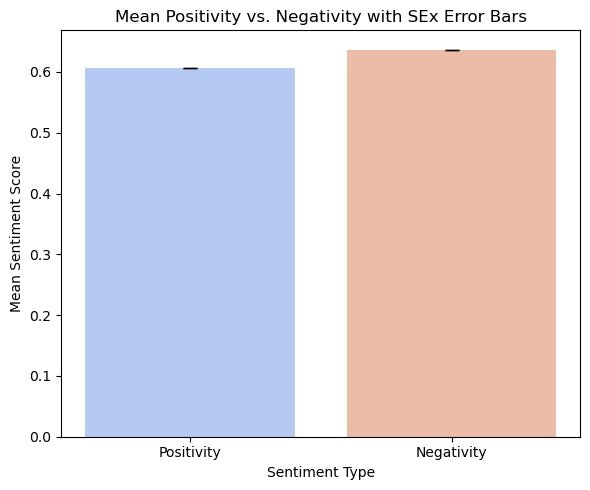

two SEx of Positivty score: 0.0003359021297136574
two SEx of Negativity score: 0.0003911769581560308


In [264]:
mean_pos = df['Positivity'].mean()
sem_pos = df['Positivity'].sem()
mean_neg = df['Negativity'].mean()
sem_neg = df['Negativity'].sem()
summary_df = pd.DataFrame({
    'Sentiment': ['Positivity', 'Negativity'],
    'Mean': [mean_pos, mean_neg],
    'SEM': [sem_pos, sem_neg]
})
plt.figure(figsize=(6, 5))
sns.barplot(data=summary_df, x='Sentiment', y='Mean', palette='coolwarm', capsize=0.2, errwidth=1)

plt.errorbar(x=[0, 1], y=summary_df['Mean'], yerr=summary_df['SEM'], fmt='none', color='black', capsize=5)
plt.title('Mean Positivity vs. Negativity with SEx Error Bars')
plt.ylabel('Mean Sentiment Score')
plt.xlabel('Sentiment Type')
plt.tight_layout()
plt.show()

print(f"two SEx of Positivty score: {sem_pos}\ntwo SEx of Negativity score: {sem_neg}")

In [265]:
## TODO: Use Mann-Whitney U Test
''' tests if the location, spread, and shape are statistically distinguishable.
 Best for non normally distributed data '''

from scipy.stats import mannwhitneyu

scores_bridge = df[df['Is_Recipient_Bridging']]['Score'].dropna()
scores_nonbridge = df[~df['Is_Recipient_Bridging']]['Score'].dropna()

stat, p = mannwhitneyu(scores_bridge, scores_nonbridge, alternative='two-sided')
print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p:.4f}")


Mann-Whitney U Test: statistic=991619406553.50, p-value=0.0000


In [266]:
sample1 = df1['Score'].sample(10000, random_state=1)
sample2 = df2['Score'].sample(10000, random_state=1)

u_stat, p_val = mannwhitneyu(sample1, sample2, alternative='two-sided')
print(f"Subsample Mann-Whitney U: U={u_stat}, p={p_val:.4g}")

Subsample Mann-Whitney U: U=48236240.5, p=1.557e-05


In [267]:
## TODO: Use Kolmogorov-Smirnov (KS) test
''' Less sensitive to sample size noise '''

from scipy.stats import ks_2samp

ks_stat, ks_p = ks_2samp(df1['Score'], df2['Score'])
print(f"KS test: statistic={ks_stat:.4f}, p-value={ks_p:.4g}")


KS test: statistic=0.0319, p-value=0


#### Consistency Checks

In [268]:
len(df[df['Is_Bridging_User']]['From-User-Id'].unique()) == len(bridging_users)

True

In [269]:
bridging_from_df = set(df[df['Is_Bridging_User']]['From-User-Id'].unique())

bridging_from_logic = set(bridging_users)

assert bridging_from_df == bridging_from_logic, "Mismatch in bridging user labeling"

In [270]:
interactions['Democrat > 0'] = interactions['Republican'] > 0
interactions['right > 0'] = interactions['right'] > 0

assert all(interactions.loc[bridging_users, ['Democrat > 0', 'Republican > 0']].all(axis=1)), \
       "Some bridging users do not interact with both sides"


KeyError: 'right'